In [1]:
#corresponding script to rda_freq_diff, except for rainband intensity based on the mean and standard deviation
#those were calculated in RDA_intensity_climo.ipynb.

#2 methods used:
#1) Analytic estimate pretending intensity is Gaussian (first guess);
#2) Bootstrapping method using actual values of intensity (cf RDA_intensity_bootstrap.ipynb)

In [1]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
#import masked arrays - important because intensity shows up as a NaN at some points
%matplotlib notebook
import numpy.ma as ma
import scipy.stats as st

In [2]:
## LOAD FROM NETCDF FILE ##
loadfile = "RDA_int_climo"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + loadfile + ".nc"
hovnc = nc.Dataset(hovname, "r")

#in this case, we're just going to load the smoothed plots of hovmoller frequency
ints_1_mean_p1 = []
ints_mean_p1 = []
ints_1_std_p1 = []
ints_std_p1 = []
ints_1_stdofmean_p1 = []
ints_stdofmean_p1 = []

ints_1_mean_p2 = []
ints_mean_p2 = []
ints_1_std_p2 = []
ints_std_p2 = []
ints_1_stdofmean_p2 = []
ints_stdofmean_p2 = []


for p1_b, p1_e, p2_b, p2_e in zip(p1_beg, p1_end, p2_beg, p2_end):

    years_p1= str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    print(years_p1)
    years_p2= str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    print(years_p2)
    
    ints_1_mean_p1.append(hovnc['int_1_mean_' + years_p1][:])
    ints_mean_p1.append(hovnc['int_mean_' + years_p1][:])
    ints_1_std_p1.append(hovnc['int_1_std_' + years_p1][:])
    ints_std_p1.append(hovnc['int_std_' + years_p1][:])
    ints_1_stdofmean_p1.append(hovnc['int_1_stdofmean_' + years_p1][:])
    ints_stdofmean_p1.append(hovnc['int_stdofmean_' + years_p1][:])
    
    ints_1_mean_p2.append(hovnc['int_1_mean_' + years_p2][:])
    ints_mean_p2.append(hovnc['int_mean_' + years_p2][:])
    ints_1_std_p2.append(hovnc['int_1_std_' + years_p2][:])
    ints_std_p2.append(hovnc['int_std_' + years_p2][:])
    ints_1_stdofmean_p2.append(hovnc['int_1_stdofmean_' + years_p2][:])
    ints_stdofmean_p2.append(hovnc['int_stdofmean_' + years_p2][:])
    
hovnc.close()

5179
8007
8093
9407


<IPython.core.display.Javascript object>


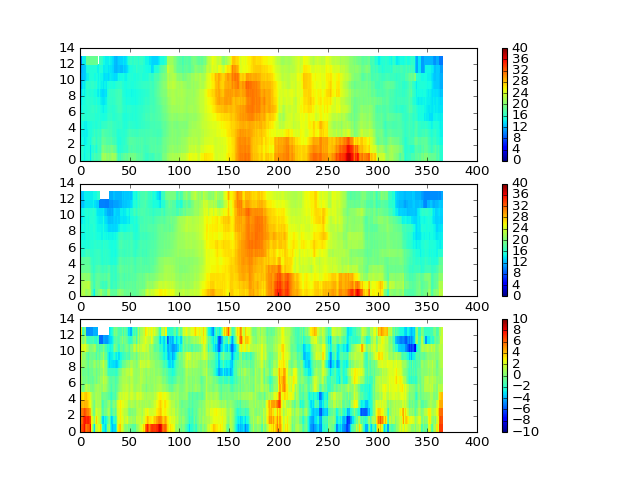

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(ints_mean_p1[0][:,3:16].T, vmin=0, vmax=40)
plt.colorbar()

ax1 = fig.add_subplot(312)
plt.pcolormesh(ints_mean_p2[0][:,3:16].T, vmin=0, vmax=40)
plt.colorbar()

ax1 = fig.add_subplot(313)
plt.pcolormesh(ints_mean_p2[0][:,3:16].T-ints_mean_p1[0][:,3:16].T, vmin=-10, vmax=10)
plt.colorbar()


In [4]:
## CALCULATE CHANGES IN INTENSITY BETWEEN TIME PERIODS
ints_1_diff = []
ints_diff = []

ints_1_Z = []
ints_Z = []

ints_1_pval = []
ints_pval = []

for int_p1, int_p1_stdofmean, int_p2, int_p2_stdofmean in zip(ints_1_mean_p1, ints_1_stdofmean_p1, ints_1_mean_p2, ints_1_stdofmean_p2):
    
    ints_1_diff.append(int_p2-int_p1)
    Zscore = (int_p2-int_p1)/((int_p1_stdofmean**2+int_p2_stdofmean**2)**.5)
    ints_1_Z.append(ma.array(Zscore, mask = np.isnan(Zscore)))
    ints_1_pval.append(ma.array(st.norm.cdf(Zscore), mask = np.isnan(Zscore).mask))
    
for int_p1, int_p1_stdofmean, int_p2, int_p2_stdofmean in zip(ints_mean_p1, ints_stdofmean_p1, ints_mean_p2, ints_stdofmean_p2):
    
    ints_diff.append(int_p2-int_p1)
    Zscore = (int_p2-int_p1)/((int_p1_stdofmean**2+int_p2_stdofmean**2)**.5)
    ints_Z.append(ma.array(Zscore, mask = np.isnan(Zscore)))
    pval = st.norm.cdf(Zscore)
    ints_pval.append(ma.array((pval), mask = np.isnan(Zscore).mask))

In [16]:
## SAVE INTENSITY DIFFERENCES AND P-VALUES AS NETCDF
outfilename = "RDA_int_diff.nc"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
fullname = ferretpath + outfilename

##the following is only to make sure that we don't exceed the bounds of the number of rows of actual data.
if os.path.isfile(fullname):
    os.remove(fullname)
    
outfile = nc.Dataset(fullname, 'w')

#use same years as chosen above:
#p1_beg = [1951,1980]
#p1_end = [1979,1993]
#p2_beg = [1980,1994]
#p2_end = [2007,2007]

#create dimensions in NetCDF file
days_dim = outfile.createDimension('time', None)
lat_dim = outfile.createDimension('lat', 22)
dim_tuple = ("time","lat")

#run through loop and save all differences of interest, as well as p-values
for p1_b, p1_e, p2_b, p2_e, int_1_diff, int_diff, int_1_Z,int_Z, int_1_pval, int_pval in \
                            zip(p1_beg, p1_end, p2_beg, p2_end, ints_1_diff, \
                            ints_diff, ints_1_Z, ints_Z, ints_1_pval, ints_pval):
    
    #convoluted line of code below guarantees that 2007 will become '07' and not '7'
    yrs_p1 = str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    yrs_p2 = str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    years = yrs_p2 + '_' + yrs_p1
    print(years)

    #create variables inside netCDF file
    ints_1_diff_out = outfile.createVariable("int_1_diff_" + years, 'f8', dim_tuple)
    ints_diff_out = outfile.createVariable("int_diff_" + years, 'f8', dim_tuple)
    
    ints_1_Z_out = outfile.createVariable("int_1_Z_" + years, 'f8', dim_tuple)
    ints_Z_out = outfile.createVariable("int_Z_" + years, 'f8', dim_tuple)
    
    ints_1_pval_out = outfile.createVariable("int_1_pval_" + years, 'f8', dim_tuple)
    ints_pval_out = outfile.createVariable("int_pval_" + years, 'f8', dim_tuple)
    
    
    #fill with actual values
    ints_1_diff_out[:] = int_1_diff
    ints_diff_out[:] = int_diff
    
    ints_1_Z_out[:] = int_1_Z
    ints_Z_out[:] = int_Z
    
    ints_1_pval_out[:] = int_1_pval
    ints_pval_out[:] = int_pval


outfile.close()


8007_5179
9407_8093
